
# Air pollution Data exploration

### Data sources
As data sources I use the data sets officially published by Geschäfts- und Koordinierungsstelle GovData, the search engine is available at https://www.govdata.de/web/guest/suchen.
The list of relevant data sets is following:

## Air quality:

Data stream **E1a** contains measured (Link to Data stream D) values of gas phase pollutants (e.g. Ozone, NO2, SO2, CO), particle pollutants (e.g. dust) and dust constituants (e.g. heavy metals, PAK in PM10, PM2.5, TSP) as well es total deposition (BULK), wet deposition and meteorologic data (e.g. temperature, wind, pressure)for every measurement location.

The data for years 2013 - 2019 is available. 

Compressed dataset is available at https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-e1a-validierte-einzelwerte-2019-datensatz.rdf. Offenheit der Lizenz: Freie Nutzung; Nutzungsbedingungen:
[Nutzungsbestimmungen für die Bereitstellung von Geodaten des Bundes ](http://www.geodatenzentrum.de/docpdf/geonutzv.pdf)
GML set is available at https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2019.zip (only for 2019 data).
 
 - Positions of the air quality sensors (Datastream D): https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-d-beurteilungsmethoden-2019-datensatz.rdf (**NB: Offenheit der Lizenz: Eingeschränkte Nutzung; Nutzungsbedingungen: Unterschiedliche Lizenzinformationen auf Distributionsebene**).

## Health related information
Starting the search at the same site (https://www.govdata.de/web/guest/suchen) it was found, that the health indicator data with a fine (county) grid is not available at this site. 

At the https://de.statista.com/statistik/ the data of interest seems to be appearing, however a payed subscription is needed.

Finally, the https://www.versorgungsatlas.de/themen/alle-analysen-nach-datum-sortiert/ site contains county-averaged data on health indicators.

 - Health indicators
   - Self-evaluation of the health status, distribution of "bad" values by counties: https://www.versorgungsatlas.de/fileadmin/excel/data_id_31_kreis_1_j_1262217600.xlsx
   - Prevalence of Heart failures in the 2017 (used for the study): https://www.versorgungsatlas.de/fileadmin/excel/data_id_97_kreis11_2_j_1483228800.xlsx
   
## Auxiliary information

In order to connect the datasets from different origin, one need to have a geotagging in the same format.
The easiest way is to stick on county-based data, attribute all air pollution sensors positions to corresponding counties. The data set containing the information on German towns and counties can be found at https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile.

### Initial Data Exploration
 - Load the data set and check it's structure, size and data quality (non-informative entries, data variability)
 - If the data set is big, make a sample subset
 - Make exploratory plots
 - May be make some e.g. hierarchical/k-means (?) clustering, finding patterns
 
### File naming conventions:

  *project_name*.**data_exp**.*technology.version.extension*  
  *project_name*.**etl**.*technology.version.extension*    
  *project_name*.**feature_eng**.*technology.version.extension*  
  *project_name*.**model_def**.*technology.version.extension*  
  *project_name*.**model_train**.*technology.version.extension*   
  *project_name*.**model_evaluate**.*technology.version.extension*   
  *project_name*.**model_deployment**.*technology.version.extension*   
    
Raw data files are placed to ./*project_name*.**rawData/**

### Loading all necessary libraries:

In [1]:
###import rdfpandas as pd
#!pip install rdflib
#!pip install networkx
#!pip install xlrd

import urllib.request
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import numpy as np

import re, collections
from io import StringIO
import os, fnmatch

import matplotlib.pyplot as plt

import geopandas as gpd
import mplleaflet

%matplotlib inline

### Creating function for printing XML file structure
It will be useful, since almost all data at GovData.de is kept in *xml* format.

In [2]:
def PrintXML(XMLfileName):
    xml_root = (etree.parse(XMLfileName)).getroot()
    raw_tree = etree.ElementTree(xml_root)
    nice_tree = collections.OrderedDict()

    for tag in xml_root.iter():
        path = re.sub('\[[0-9]+\]', '', raw_tree.getpath(tag))
        if path not in nice_tree:
            nice_tree[path] = []
        if len(tag.keys()) > 0:
            nice_tree[path].extend(attrib for attrib in tag.keys() if attrib not in nice_tree[path])            
 
    for path, attribs in nice_tree.items():
        indent = int(path.count('/') - 1)
        print('{0}{1}: {2} [{3}]'.format('    ' * indent, indent, path.split('/')[-1], ', '.join(attribs) if len(attribs) > 0 else '-'))

### Downloading the data
The code chunk is commented out in order to prevent multiple download of data.

In [3]:
## Download and decompress the dataset itself:
#!mkdir Correlaid.rawData
#!mkdir Correlaid.rawData/AQD_DE_E1a_2019
#!ls -l Correlaid.rawData/
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2019.zip", "Correlaid.rawData/AQD_DE_E1a_2019.zip")
#!mv Correlaid.rawData/AQD_DE_E1a_2019.zip Correlaid.rawData/AQD_DE_E1a_2019/
#!unzip Correlaid.rawData/AQD_DE_E1a_2019/AQD_DE_E1a_2019.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_E1a_2019/AQD_DE_E1a_2019.zip
#!unzip Correlaid.rawData/DISKO.zip -d Correlaid.rawData/AQD_DE_E1a_2019/
#!unzip Correlaid.rawData/KONTI.zip -d Correlaid.rawData/AQD_DE_E1a_2019/
#!rm Correlaid.rawData/DISKO.zip Correlaid.rawData/KONTI.zip

#Download the rdf
#urllib.request.urlretrieve("https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-e1a-validierte-einzelwerte-2019-datensatz.rdf", "Correlaid.rawData/AQD_DE_E1a_2019/luftqualitatsdaten-datenstrom-e1a-validierte-einzelwerte-2019-datensatz.rdf")

#Download Sensor positions
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_D_2019.zip", "Correlaid.rawData/AQD_DE_D_2019.zip")
#!unzip Correlaid.rawData/AQD_DE_D_2019.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_D_2019.zip

# Download Town-county dataset:
#urllib.request.urlretrieve("https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile",
#                           "Correlaid.rawData/GV100AD3107.zip")
#!mkdir Correlaid.rawData/GV100AD3107
#!unzip Correlaid.rawData/GV100AD3107.zip -d Correlaid.rawData/GV100AD3107/
#!rm Correlaid.rawData/GV100AD3107.zip

#!mkdir Correlaid.rawData/Geo
#urllib.request.urlretrieve("https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip", "Correlaid.rawData/Geo/DEU_adm.zip" 
#!unzip Correlaid.rawData/Geo/DEU_adm.zip -d Correlaid.rawData/Geo/

#!ls -la Correlaid.rawData/
#!ls -la Correlaid.rawData/AQD_DE_E1a_2019/
#!ls -la Correlaid.rawData/GV100AD3107/

#!pwd

### Dataset files analysis
Let's take a look at the downloaded data set:

In [4]:
!ls -la Correlaid.rawData/AQD_DE_E1a_2019/

total 2625248
drwxr-xr-x  50 gorelov  staff       1600 Jul 15 12:11 .
drwxr-xr-x   7 gorelov  staff        224 Jul 21 12:55 ..
-rw-r--r--   1 gorelov  staff     659093 Jul 17  2020 DE_BB_2019_day.xml
-rw-r--r--   1 gorelov  staff    1184013 Sep 11  2020 DE_BB_2019_discontinuous.xml
-rw-r--r--   1 gorelov  staff   85213645 Jul 17  2020 DE_BB_2019_hour.xml
-rw-r--r--   1 gorelov  staff     123320 Jul 17  2020 DE_BE_2019_day.xml
-rw-r--r--   1 gorelov  staff     368893 Sep 11  2020 DE_BE_2019_discontinuous.xml
-rw-r--r--   1 gorelov  staff   41046836 Jul 17  2020 DE_BE_2019_hour.xml
-rw-r--r--   1 gorelov  staff    2013215 Jul 17  2020 DE_BW_2019_day.xml
-rw-r--r--   1 gorelov  staff     646378 Sep 11  2020 DE_BW_2019_discontinuous.xml
-rw-r--r--   1 gorelov  staff   85962548 Jul 17  2020 DE_BW_2019_hour.xml
-rw-r--r--   1 gorelov  staff     283611 Sep 11  2020 DE_BY_2019_discontinuous.xml
-rw-r--r--   1 gorelov  staff  154930318 Jul 17  2020 DE_BY_2019_hour.xml
-rw-r--r--   1 gorelov  st

It is clear, that filenames contain information on the file contents:
e.g. **DE_HH_2019_hour.xml**: **DE** for Germany, **HH** for Hansestadt Hamburg, **2019** for year of measurements,  **hour** for type of measurements (hourly averaged).  

Now let's take a look at the *xml* file structure:

In [5]:

PrintXML("Correlaid.rawData/AQD_DE_E1a_2019/DE_HH_2019_hour.xml")


0: gml:FeatureCollection [{http://www.w3.org/2001/XMLSchema-instance}schemaLocation, {http://www.opengis.net/gml/3.2}id]
    1: gml:featureMember [-]
        2: om:OM_Observation [{http://www.opengis.net/gml/3.2}id]
            3: om:phenomenonTime [-]
                4: gml:TimePeriod [{http://www.opengis.net/gml/3.2}id]
                    5: gml:beginPosition [-]
                    5: gml:endPosition [-]
            3: om:resultTime [-]
                4: gml:TimeInstant [{http://www.opengis.net/gml/3.2}id]
                    5: gml:timePosition [-]
            3: om:procedure [{http://www.w3.org/1999/xlink}href]
            3: om:parameter [-]
                4: om:NamedValue [-]
                    5: om:name [{http://www.w3.org/1999/xlink}href]
                    5: om:value [{http://www.w3.org/1999/xlink}href, {http://www.w3.org/2001/XMLSchema-instance}type]
            3: om:observedProperty [{http://www.w3.org/1999/xlink}href]
            3: om:featureOfInterest [{http://ww

Again, a lot of urls describing standards, however the structure of file becomes clearer.
Let's check the first rank entries from the root:

In [6]:
xml_tree = etree.parse("Correlaid.rawData/AQD_DE_E1a_2019/DE_HH_2019_hour.xml")
xml_root = xml_tree.getroot()
for child in xml_root:
    print(child.tag, child.attrib) 

{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.

It seems to be, that the file can contain measurements from 25 sensors at different locations (as it will be shown later, actual file contains only 24 sensors data, the first entry is used for auxiliary information). 
An *xml* file entry consist of three possible elements: **tag**, like key or variable name; **attrib**, like value of variable, and **text**, that accommodates everything between corresponding tags (up to video in *base64* encoding). 
For the further use I will collect all the **tag**s from the dataset file and store it to the *AllTags* list.


In [7]:
# pick all tags from the XML file
Etree = ET.parse("Correlaid.rawData/AQD_DE_E1a_2019/DE_HH_2019_hour.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
print(AllTags[23:35])
#varName = 'observedProperty'
#print("\n".join([s for s in AllTags if varName in s]))    

['{http://www.isotc211.org/2005/gmd}result', '{http://www.isotc211.org/2005/gmd}DQ_ConformanceResult', '{http://www.isotc211.org/2005/gmd}specification', '{http://www.isotc211.org/2005/gmd}CI_Citation', '{http://www.isotc211.org/2005/gmd}title', '{http://www.isotc211.org/2005/gco}CharacterString', '{http://www.isotc211.org/2005/gmd}date', '{http://www.isotc211.org/2005/gmd}CI_Date', '{http://www.isotc211.org/2005/gmd}date', '{http://www.isotc211.org/2005/gco}Date', '{http://www.isotc211.org/2005/gmd}dateType', '{http://www.isotc211.org/2005/gmd}CI_DateTypeCode']


## Exploring Dataset XML structure
First of all, let's write functions, that will fetch *xml* tags by contained keyword.
The ideas about keywords needed can be got from looking at *AllTags* list.
The function *FetchAllXMLsensor* parses the sensor ID from the corresponding *xml* **attr**
at the **value** tag.

In [8]:
def FetchXMLentryByWord(varName, NumToPrint):
    varFull = [s for s in AllTags if varName in s][NumToPrint]
    print(varFull)
    print([(varr.attrib, varr.text) for varr in Eroot.iter(varFull)][NumToPrint])
    print('\n')
def FetchAllXMLentriesByWord(varName):
    varFull = [s for s in AllTags if varName in s][0]
    print([(varr.attrib) for varr in Eroot.iter(varFull)])
    print('\n')
def FetchAllXMLsensorID():
    varFull = [s for s in AllTags if 'value' in s][0]
    print([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 
    print('\n')
def SelectAllXMLsensorID():
    varFull = [s for s in AllTags if 'value' in s][0]
    return([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 
    

Using the Fetch functions, one can show, that units of measurements in this *xml* file are **microgramm pro cubic meter**, the pollutant is of type 9 (according to the given url it is **NOX as NO2**)  and observation time os an **hour**. 

One can parse sensor IDs in form of **DEBB007_NOx_dataGroup1**,
where **DE** stands for Germany, **BB** for Brandenburg region, **007** is the sensor number (this information will be used later for geotagging), **NOx** for kind of pollutant (nitrogen oxides), and the **dataGroup1** is some common index.

The pollutant concentration data is stored in **text** fields of the entries with **value** tag; the data is stored in the *csv* format, end line symbol is "@@":

In [9]:
FetchXMLentryByWord('Quantity', 0)

FetchXMLentryByWord('uom', 2)    
FetchXMLentryByWord('observedProperty', 0)    

FetchAllXMLsensorID()

FetchXMLentryByWord('TextEncoding', 0)
ColNamesExp=SelectAllXMLsensorID()

{http://www.opengis.net/swe/2.0}Quantity
({'definition': 'http://dd.eionet.europa.eu/vocabulary/aq/primaryObservation/hour'}, '\n                ')


{http://www.opengis.net/swe/2.0}uom
({'{http://www.w3.org/1999/xlink}href': 'http://dd.eionet.europa.eu/vocabulary/uom/concentration/ug.m-3'}, None)


{http://www.opengis.net/om/2.0}observedProperty
({'{http://www.w3.org/1999/xlink}href': 'http://dd.eionet.europa.eu/vocabulary/aq/pollutant/20'}, None)


['DEHH068_CHB_dataGroup1', 'DEHH070_CHB_dataGroup1', 'DEHH008_NO2_dataGroup1', 'DEHH015_NO2_dataGroup1', 'DEHH016_NO2_dataGroup1', 'DEHH026_NO2_dataGroup1', 'DEHH033_NO2_dataGroup1', 'DEHH047_NO2_dataGroup1', 'DEHH050_NO2_dataGroup1', 'DEHH059_NO2_dataGroup1', 'DEHH064_NO2_dataGroup1', 'DEHH068_NO2_dataGroup1', 'DEHH070_NO2_dataGroup1', 'DEHH072_NO2_dataGroup1', 'DEHH073_NO2_dataGroup1', 'DEHH079_NO2_dataGroup1', 'DEHH081_NO2_dataGroup1', 'DEHH008_PM1_dataGroup1', 'DEHH015_PM1_dataGroup1', 'DEHH016_PM1_dataGroup1', 'DEHH026_PM1_dataGroup1'

## Reading Pollutant concentration Measurements to DataFrame
For exploratory analysis the data should be loaded to some toolbox, in this case *Pandas* in form of *Pandas Dataframe*. As it was shown before, one have to parse **text** fields of the entries with **value** tag as a normal *csv* file: 

In [10]:
varFull = [s for s in AllTags if 'values' in s][0]

dff=[]
for varr in Eroot.iter(varFull):
    dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))

In [11]:
[dff[s].shape for s in range(0,len(dff))]

[(8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5),
 (8760, 5)]

In [12]:
len(dff)

79

In [13]:
dff[78].tail(5)

,0,1,2,3,4
8755,2019-12-31T19:00:00+01:00,2019-12-31T20:00:00+01:00,1,1,185.311
8756,2019-12-31T20:00:00+01:00,2019-12-31T21:00:00+01:00,1,1,98.057
8757,2019-12-31T21:00:00+01:00,2019-12-31T22:00:00+01:00,1,1,122.113
8758,2019-12-31T22:00:00+01:00,2019-12-31T23:00:00+01:00,1,1,124.006
8759,2019-12-31T23:00:00+01:00,2019-12-31T24:00:00+01:00,1,1,268.890


From the chunks above one can see that in the current **DE_HH_2019_hour.xml** file there is measurement data for 79 sensors, each containing **8760** values - one measurement for each hour of the year. At least in the current file there are no NA values:

In [14]:
[dff[s].isnull().sum() for s in range(0,len(dff))]

[0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3    0
 4    0
 dtype: int64, 0    0
 1    0
 2    0
 3  

<Figure size 432x288 with 0 Axes>

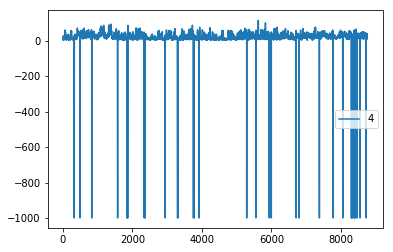

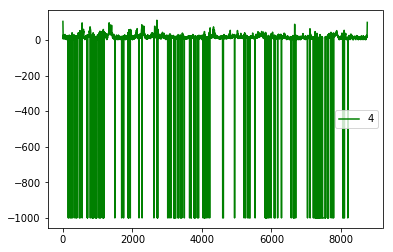

In [15]:
plt.figure()
((dff[2])[[4]]).plot()
((dff[22])[[4]]).plot(style='g')


From the figures above it is clear that the data contains also failed measurements, encoded as negative values (pollutant concentration cannot be negative). It means that *imputting* strategy should be developed in order to treat the problem. At the moment these negative values will be replaced with zeros, it will cause no problem for initial exploratory analysis:

In [16]:
dffAll=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
dffAll.columns=ColNamesExp
dffAll=dffAll.clip(lower=0)
dffAll.head(5)

,DEHH068_CHB_dataGroup1,DEHH070_CHB_dataGroup1,DEHH008_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH016_NO2_dataGroup1,DEHH026_NO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH047_NO2_dataGroup1,DEHH050_NO2_dataGroup1,DEHH059_NO2_dataGroup1,...,DEHH016_SO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH079_SO2_dataGroup1,DEHH081_SO2_dataGroup1,DEHH008_PM2_dataGroup1,DEHH015_PM2_dataGroup1,DEHH033_PM2_dataGroup1,DEHH059_PM2_dataGroup1,DEHH064_PM2_dataGroup1,DEHH068_PM2_dataGroup1
0,2.182,0.977,23.896,16.787,13.292,30.217,14.883,13.441,10.037,12.743,...,2.500,2.5,2.5,2.500,98.733,116.412,51.636,88.387,216.470,602.380
1,0.693,0.773,13.698,11.791,16.222,19.486,6.349,6.496,4.000,6.534,...,2.500,2.5,2.5,9.531,33.534,96.405,75.457,65.468,161.832,80.708
2,0.454,0.675,7.991,6.998,15.669,12.586,6.243,4.708,2.000,7.821,...,2.500,2.5,2.5,11.270,24.592,25.195,15.651,13.072,18.958,36.882
3,0.200,0.000,7.322,5.273,14.999,12.025,4.714,4.130,2.000,4.483,...,2.500,2.5,2.5,2.500,22.920,16.258,11.641,12.416,13.909,36.853
4,0.000,0.000,6.211,5.665,13.821,9.234,5.180,2.000,2.000,4.407,...,5.926,2.5,2.5,2.500,30.757,19.862,15.598,17.161,17.068,47.537


Now we can plot selected **DE_HH_2019_hour.xml** file as a timeseries: 

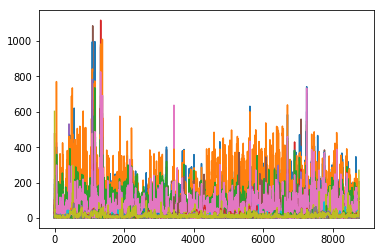

In [17]:
dffAll.plot(legend=None)

We can take a look at sensors data distributions (all sensors in Hamburg area are shown):

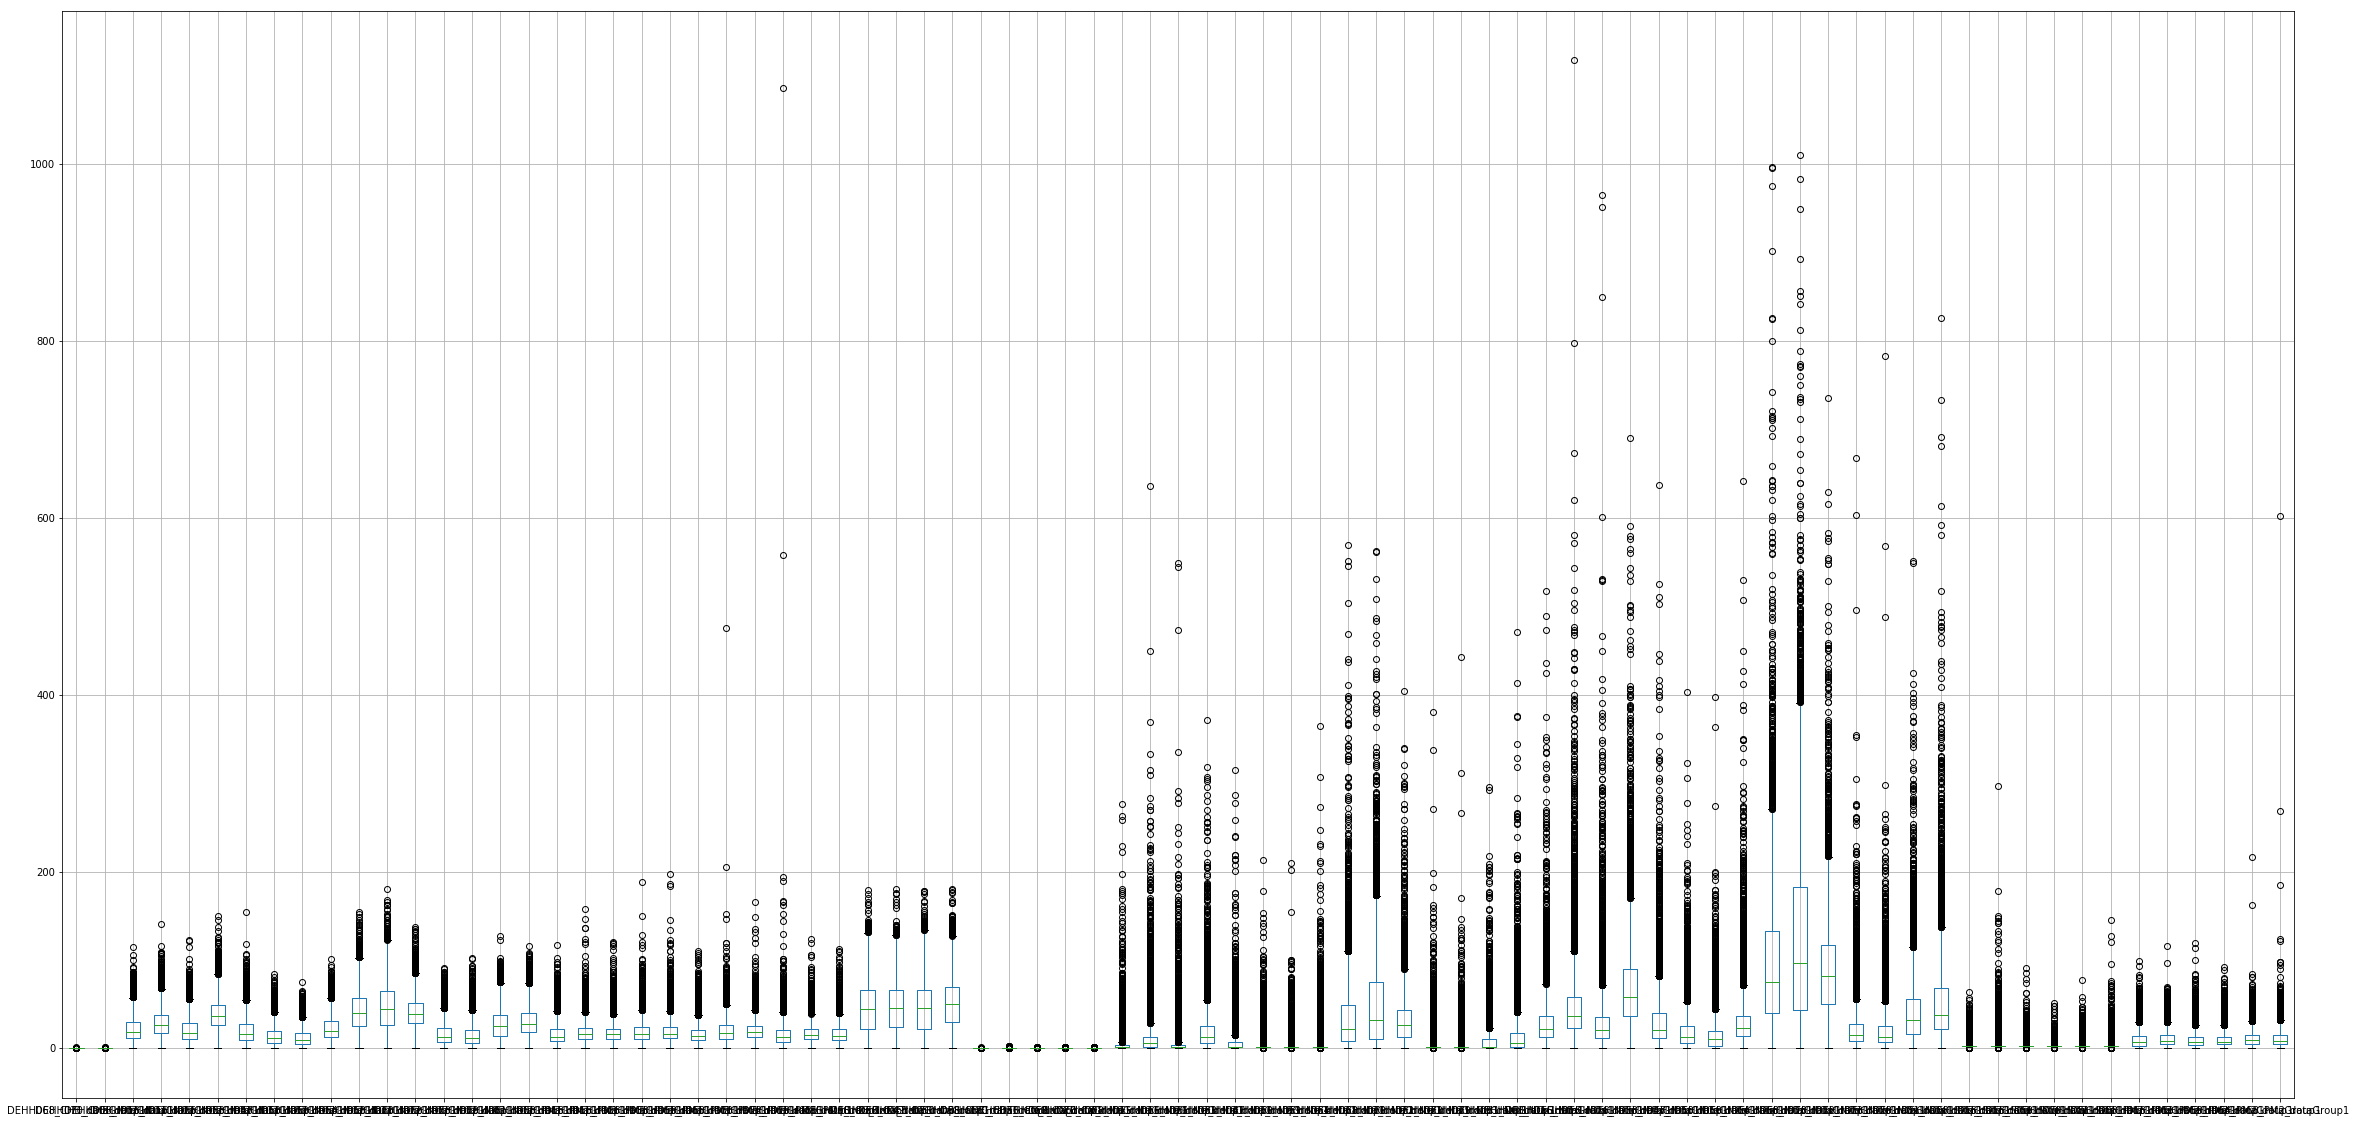

In [18]:
dffAll.boxplot(figsize=(40, 20))

On the figure above one can see that different sensors (apart 7 dead sensors) demonstrate significantly different statistics, so the data variativity should be enough to be used in the project.

## Sensor position data
Let's examine the xml file with sensor position data. The sensor IDs are encoded by *text* of **natlStationCode** and **EUStationCode** tags, and the name of municipality is in *text* of **municipality** tag. More detailed location information, like coordinates (**pos**) and elevation (**altitude**) is available.

In [19]:
# pick all tags from the XML file
Etree = etree.parse("Correlaid.rawData/DE_D_allInOne_metaMeasurements_2019.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
print(AllTags[23:35])
#varName = 'observedProperty'
#print("\n".join([s for s in AllTags if varName in s])) 

['{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}municipality', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}EUStationCode', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}stationInfo', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}areaClassification', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}altitude', '{http://www.opengis.net/gml/3.2}featureMember', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}AQD_SamplingPoint', '{http://inspire.ec.europa.eu/schemas/ef/3.0}inspireId', '{http://inspire.ec.europa.eu/schemas/base/3.3}Identifier', '{http://inspire.ec.europa.eu/schemas/base/3.3}localId', '{http://inspire.ec.europa.eu/schemas/base/3.3}namespace', '{http://inspire.ec.europa.eu/schemas/base/3.3}versionId']


In [20]:
#len(AllTags)
varMUN = [s for s in AllTags if 'municipality' in s][0]
varID  = [s for s in AllTags if 'EUStationCode' in s][0]
varPOS  = [s for s in AllTags if 'pos' in s][0]
varFeatMem = [s for s in AllTags if 'featureMember' in s][0]


IDs = []
MUNs = []
POSs = []
LONGs = []
LATs = []

for varr in Eroot.iter(varFeatMem):
    for child in varr.iter(varMUN):
        MUNs.append(child.text)
        for child2 in varr.iter(varID):
            IDs.append(child2.text)
        for child3 in varr.iter(varPOS):
            LONGs.append(float(child3.text.split()[0]))
            LATs.append(float(child3.text.split()[1]))
            
SensorLocation = pd.DataFrame({'SensorID': IDs, 'SensorTown': MUNs, 'SensorLong': LONGs, 'SensorLat': LATs})
SensorLocation.tail(5)

,SensorID,SensorTown,SensorLong,SensorLat
876,DEUB005,Lüder,52.800773,10.756733
877,DEUB028,Zingst,54.436985,12.721938
878,DEUB029,Suhl,50.654066,10.769534
879,DEUB030,Stechlin,53.141303,13.031662
880,DEUB044,Garmisch-Partenkirchen,47.414436,10.980657


Since in the current project we are interested in the informations from measuring stations located in Hamburg,
Let' s select only ones having ID containing **DEHH** and remove duplicates:

In [21]:
SensorLocationHH = SensorLocation[SensorLocation.SensorID.str.contains("DEHH")].copy()
SensorLocationHH.drop_duplicates(inplace=True, ignore_index=True)
SensorLocationHH.tail()

,SensorID,SensorTown,SensorLong,SensorLat
17,DEHH076,Hamburg,53.467561,9.971706
18,DEHH078,Hamburg,53.551042,9.965585
19,DEHH079,Hamburg,53.545269,9.944815
20,DEHH080,Hamburg,53.547355,9.987920
21,DEHH081,Hamburg,53.529158,9.981599


We can see, that the list contains information on **21** measuring stations.

### Now we can get a map view for the sensors positions:
The polygon vertexes can be obtained from
https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip.

In [22]:
de_shape_df = gpd.read_file("Correlaid.rawData/Geo/DEU_adm1.shp")
de_shape_df.head(7)

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,86,DEU,Germany,1,Baden-Württemberg,Land,State,None,None,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."
1,86,DEU,Germany,2,Bayern,Land,State,None,Bavaria,"POLYGON ((10.13386 50.55000, 10.13980 50.54252..."
2,86,DEU,Germany,3,Berlin,Land,State,None,None,"POLYGON ((13.17789 52.39032, 13.16575 52.39050..."
3,86,DEU,Germany,4,Brandenburg,Land,State,None,None,"POLYGON ((13.87951 53.50107, 13.87927 53.49908..."
4,86,DEU,Germany,5,Bremen,Land,State,None,None,"MULTIPOLYGON (((8.50506 53.23289, 8.51754 53.2..."
5,86,DEU,Germany,6,Hamburg,Land,State,None,None,"POLYGON ((10.07162 53.71823, 10.07150 53.72192..."
6,86,DEU,Germany,7,Hessen,Land,State,None,Hesse,"POLYGON ((9.49877 51.63152, 9.50474 51.62795, ..."


In [23]:
hamburg_shape_df = de_shape_df.query('NAME_1 == "Hamburg"')

### Stations positions with stations names:

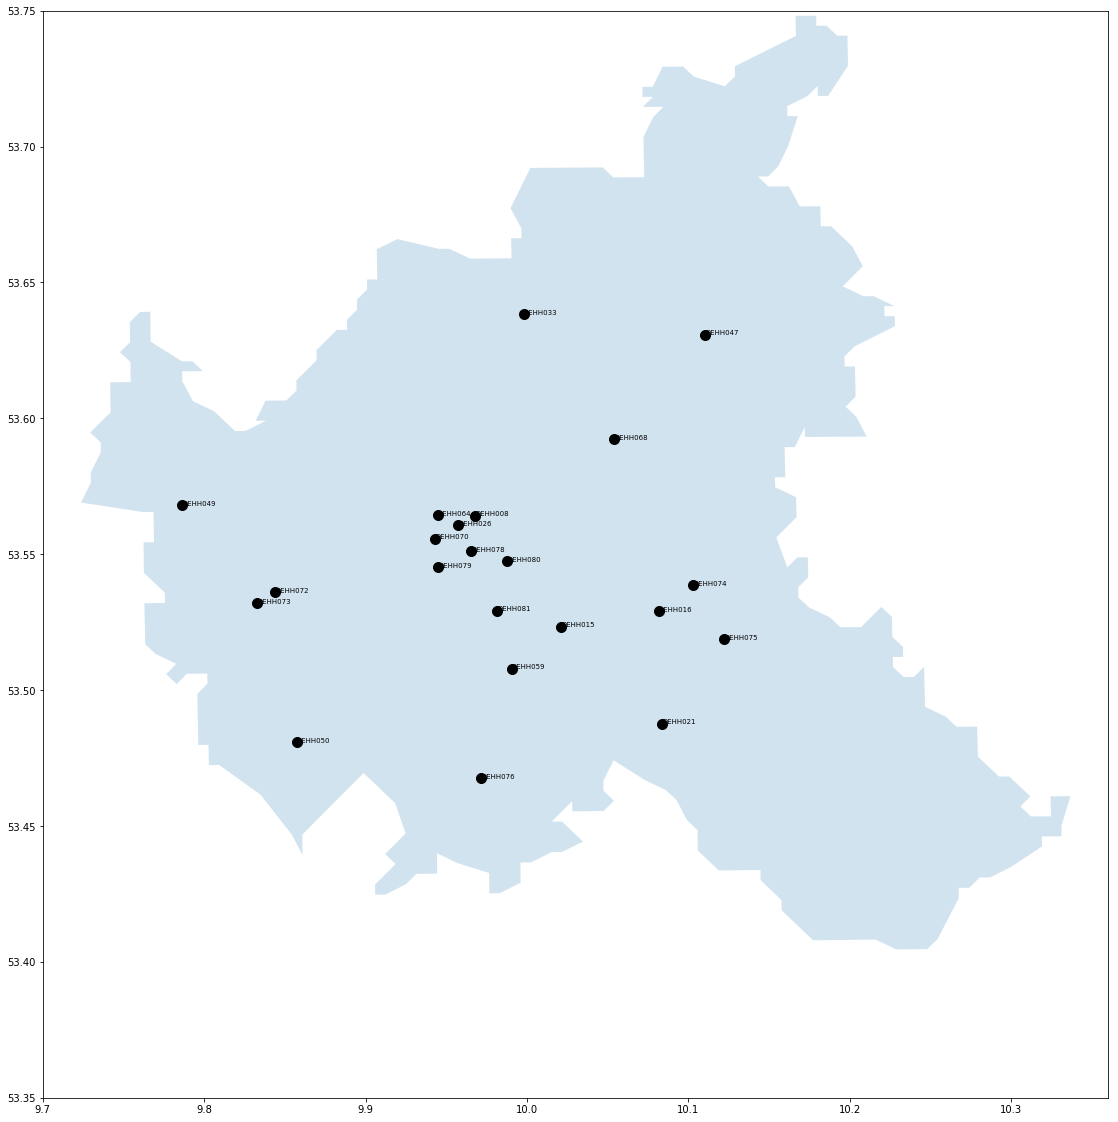

In [37]:
fig, ax = plt.subplots(figsize=(40, 20))

hamburg_shape_df.plot(
    ax=ax, 
    alpha=0.2
)

plt.xlim(9.7, 10.36)  # not to show the islands that belongs to Hamburg
plt.ylim(53.35, 53.75)

ax.scatter(
    np.array(SensorLocationHH["SensorLat"]), 
    np.array(SensorLocationHH["SensorLong"]), 
    marker='o',
    c='black',
    s=100,
    alpha=1.0
)

for index, row in SensorLocationHH.iterrows():
    ax.annotate(row["SensorID"], (row["SensorLat"], row["SensorLong"]), fontsize=7, alpha=1.0)  
plt.show()

### Stations positions on the interactive map:

In [25]:
fig, ax = plt.subplots()

plt.xlim(9.6, 10.4)  # not to show the islands that belongs to Hamburg
plt.ylim(53.35, 53.75)

ax.scatter(
    np.array(SensorLocationHH["SensorLat"]), 
    np.array(SensorLocationHH["SensorLong"]), 
    marker='o',
    c='black',
    s=30,
    alpha=1.0
)

mplleaflet.display(fig=fig)

/usr/local/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
